In [1]:
import os
import random
import imageio
import glob
import datetime
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa

from keras import layers
from keras import models
from keras.models import Model




from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score


c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you

In [2]:
#Function to get the paths from the directory

def get_files(base_dir, ext=None):
    assert type(ext) in [list, str]
    ext = [ext] if type(ext)!= list else ext
    ret_files = []
    
    for f in glob.glob(f'{base_dir}/**', recursive=True):
        if (ext is not None) and not any([f.endswith(e) for e in ext]):
            continue
        ret_files.append(f)
        
    return ret_files

In [3]:
#Get paths and labels

root_directory = "data\\dataset_2_final\\"
class_names = sorted([f for f in os.listdir(root_directory) if not f.startswith('.')])
class2int = dict(zip(class_names, range(len(class_names))))
num_classes = len(class_names)
image_paths = get_files(root_directory, 'jpg')
labels = list(map(lambda im: class2int[im.split(root_directory)[1].split('\\')[0]], image_paths))
np.unique(labels, return_counts=True)


(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 70,  62,  60, 124,  57,  65,  56], dtype=int64))

In [4]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=8, image_size=255, shuffle_epoch=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle_epoch = shuffle_epoch
        
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, idx):
        
        if (idx == 0) and (self.shuffle_epoch):            
            # Shuffle at first batch
            c = list(zip(self.images, self.labels))
            random.shuffle(c)
            self.images, self.labels = zip(*c)
            self.images, self.labels = np.array(self.images), np.array(self.labels)       
        
        images = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        labels = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        # Read images
        images = np.array([imageio.v2.imread(im) for im in images])
        
        # Choose one of the four quadrants
        x, y = np.random.choice([0,1], size=2)
        images = images[:,(x*600):(x*600 + 600), (y*800):(y*800 + 800)]
        
        #Todos los modelos tienen capa de rescaling por lo que no es necesaria aqui
        # images = images/255
        
        images = np.array([self.random_crop(im) for im in images])
        labels = to_categorical(labels, num_classes=num_classes)
        
        return images, labels
    
    def random_crop(self, image):
        cropped_image = tf.image.random_crop(image, size=[self.image_size, self.image_size, 3]).numpy()
        return cropped_image


For reference: 

- Private images are 1600x1200 (800 x 600 when splitted)
- Public images are 768 x 768

In [5]:
#Split in training and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


#Build the generators
train_generator = CustomDataGenerator(train_paths, train_labels)
val_generator = CustomDataGenerator(val_paths, val_labels, shuffle_epoch=False)


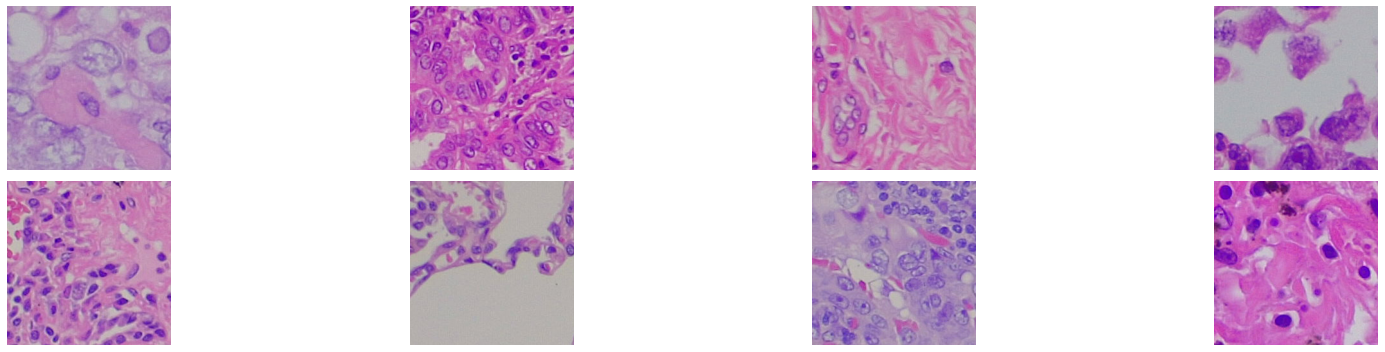

In [6]:
fig, axs = plt.subplots(2,4, figsize=(25,5))
axs = axs.flatten()

for i in range(8):
    gen = train_generator if i<4 else val_generator
    axs[i].imshow(gen[1][0][i%10])
    axs[i].axis('off')
plt.tight_layout()
plt.show()


In [7]:
# I moved this up here. Check if it still runs

labels = np.concatenate([l.argmax(1) for _, l in tqdm(gen, leave=False)])
class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(labels),
                                                     y=list(labels))
class_weights = dict(enumerate(class_weights))
class_weights

  0%|          | 0/13 [00:00<?, ?it/s]

{0: 1.010204081632653,
 1: 0.7443609022556391,
 2: 1.7678571428571428,
 3: 0.673469387755102,
 4: 2.020408163265306,
 5: 0.9428571428571428,
 6: 0.9428571428571428}

In [ ]:
#function to plot the metrics of the trainign and validation

def plot_metrics(history):
    # Plotting training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['metrics/accuracy'], label='Train')
    plt.plot(history.history['val_metrics/accuracy'], label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# EFFICIENTNET

In [8]:
base_model = EfficientNetB0(include_top = False ,weights='imagenet', pooling='avg')

# Introduce a layer of data augmentation
data_augmentation = Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
])

# # Freeze all layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False
# # Unfreeze the last 10 layers in the base model for fine-tuning
# for layer in base_model.layers[-5:]:
#     layer.trainable = True

#capa de entradas. 
entradas = layers.Input((255, 255, 3))

# Capa de augmentation
x = data_augmentation(entradas)
# Pass the augmented images through the base model
x = base_model(x)
# Add a dense layer
x = layers.Dense(128, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs = entradas, outputs = salidas)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 4,214,442
Trainable params: 4,172,419
Non-trainable params: 42,023
_________________________________________________________________


In [9]:
import datetime

In [10]:
MODEL_NAME = 'Ef0'
RUN_NAME = ''
log_dir = f'logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/{MODEL_NAME}{RUN_NAME}'


In [11]:
num_epochs = 80
patience = 15
patience_lr = 15

model1.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=[
                    tf.keras.metrics.CategoricalAccuracy(name=f'metrics/accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(3, name=f'metrics/top-3-accuracy'),
                    tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='metrics/F1-macro'),
                    tf.keras.metrics.AUC(multi_label=True, num_labels=num_classes, name='metrics/AUC'),
                    tf.keras.metrics.Precision(name='metrics/precision'),
                    tf.keras.metrics.Recall(name='metrics/recall'),
                    tf.keras.metrics.PrecisionAtRecall(0.99, name='metrics/P@R_99'),
                    tf.keras.metrics.PrecisionAtRecall(0.95, name='metrics/P@R_95'),
                    tf.keras.metrics.PrecisionAtRecall(0.9, name='metrics/P@R_90'),
                    tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes, name='metrics/MCC')
                ],
             )

callbacks =[
       EarlyStopping(monitor='metrics/val_loss', restore_best_weights=True, patience=patience),
       ReduceLROnPlateau(monitor='metrics/val_loss', patience=patience_lr, min_lr=1e-7),       
       ModelCheckpoint(log_dir, monitor=f"metrics/val_loss", save_best_only=True, save_weights_only=True),
       TqdmCallback(),
       TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [12]:
# Train the model using the custom data generators and the debugging callback
history = model1.fit(train_generator, epochs=num_epochs, verbose=1, callbacks=callbacks, validation_data=val_generator,class_weight=class_weights)

c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/80
50/50 [==============================] - 150s 2s/step - loss: 1.8755 - metrics/val_accuracy: 0.3215 - metrics/top-3-accuracy: 0.6608 - metrics/F1-macro: 0.2635 - metrics/AUC: 0.6911 - metrics/precision: 0.4824 - metrics/recall: 0.1038 - metrics/P@R_99: 0.1476 - metrics/P@R_95: 0.1661 - metrics/P@R_90: 0.1780 - metrics/MCC: 0.1935 - val_loss: 3.4255 - val_metrics/val_accuracy: 0.1414 - val_metrics/top-3-accuracy: 0.5859 - val_metrics/F1-macro: 0.0725 - val_metrics/AUC: 0.5862 - val_metrics/precision: 0.1429 - val_metrics/recall: 0.1010 - val_metrics/P@R_99: 0.1429 - val_metrics/P@R_95: 0.1429 - val_metrics/P@R_90: 0.1429 - val_metrics/MCC: 0.0634
Epoch 2/80
50/50 [==============================] - 96s 2s/step - loss: 1.7280 - metrics/val_accuracy: 0.3823 - metrics/top-3-accuracy: 0.7570 - metrics/F1-macro: 0.3374 - metrics/AUC: 0.7686 - metrics/precision: 0.5223 - metrics/recall: 0.2076 - metrics/P@R_99: 0.1490 - metrics/P@R_95: 0.1856 - metrics/P@R_90: 0.2035 - metrics/MCC: 

In [13]:
print(history.history.keys())


dict_keys(['loss', 'metrics/val_accuracy', 'metrics/top-3-accuracy', 'metrics/F1-macro', 'metrics/AUC', 'metrics/precision', 'metrics/recall', 'metrics/P@R_99', 'metrics/P@R_95', 'metrics/P@R_90', 'metrics/MCC', 'val_loss', 'val_metrics/val_accuracy', 'val_metrics/top-3-accuracy', 'val_metrics/F1-macro', 'val_metrics/AUC', 'val_metrics/precision', 'val_metrics/recall', 'val_metrics/P@R_99', 'val_metrics/P@R_95', 'val_metrics/P@R_90', 'val_metrics/MCC', 'lr'])


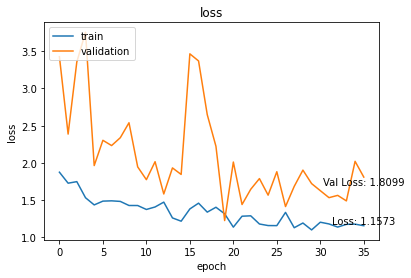

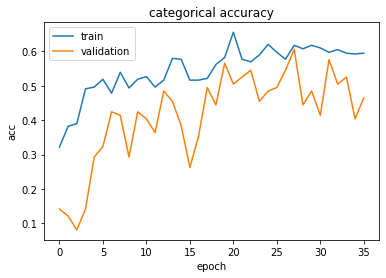

In [23]:

#  "Accuracy"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')

# plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"

plt.plot(history.history['metrics/accuracy'])         # Training accuracy
plt.plot(history.history['val_metrics/val_accuracy'])     # Validation accuracy
plt.title('categorical accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')


# plt.savefig(folder_date + "/loss.png")
plt.show()

### Test

In [15]:
test_directory = "data\\validation_final_septiembre\\"
test_image_paths = get_files(test_directory, 'jpg')
test_labels = [class2int[im.split(test_directory)[1].split('\\')[0]] for im in test_image_paths]

test_generator = CustomDataGenerator(test_image_paths, test_labels, shuffle_epoch=False)
test_predictions = model1.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(test_predictions, axis=1)


Test Accuracy: 0.2571428571428571
Test Precision: 0.34556277056277057
Test Recall: 0.2571428571428571


c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


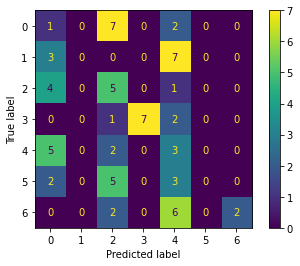

In [16]:
# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)



# Obtain the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Ensure that labels are unique and match the confusion matrix
labels = np.unique(np.concatenate((test_labels, predicted_labels)))

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot()


For dubug purposes only. I load a model that is trained already

In [ ]:
# !tensorboard --logdir=logs

# RESNET 50

In [24]:
base_model = ResNet50(include_top = False ,weights='imagenet', pooling='avg')

# Introduce a layer of data augmentation
data_augmentation = Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
])

# # Freeze all layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False
# # Unfreeze the last 2 layers in the base model for fine-tuning
# for layer in base_model.layers[-2:]:
#     layer.trainable = True

#capa de entradas. 
entradas = layers.Input((255, 255, 3))

# Rescaling layer to scale pixel values between 0 and 1
x = Rescaling(scale=1./255)(entradas)

# Capa de augmentation
x = data_augmentation(entradas)
# Pass the augmented images through the base model
x = base_model(x)
# Add a dense layer
x = layers.Dense(64, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(num_classes, activation='softmax')(x)
model2 = Model(inputs = entradas, outputs = salidas)
model2.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 23,719,303
Trainable params: 23,666,183
Non-trainable params: 53,120
_________________________________________________________________


In [25]:
num_epochs = 70
patience = 15
patience_lr = 15

model2.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=[
                    tf.keras.metrics.CategoricalAccuracy(name=f'metrics/accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(3, name=f'metrics/top-3-accuracy'),
                    tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='metrics/F1-macro'),
                    tf.keras.metrics.AUC(multi_label=True, num_labels=num_classes, name='metrics/AUC'),
                    tf.keras.metrics.Precision(name='metrics/precision'),
                    tf.keras.metrics.Recall(name='metrics/recall'),
                    tf.keras.metrics.PrecisionAtRecall(0.99, name='metrics/P@R_99'),
                    tf.keras.metrics.PrecisionAtRecall(0.95, name='metrics/P@R_95'),
                    tf.keras.metrics.PrecisionAtRecall(0.9, name='metrics/P@R_90'),
                    tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes, name='metrics/MCC')
                ],
             )

callbacks =[
       EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience),
       ReduceLROnPlateau(monitor='val_loss', patience=patience_lr, min_lr=1e-7),       
       ModelCheckpoint(log_dir, monitor=f"val_loss", save_best_only=True, save_weights_only=True),
       TqdmCallback(),
       TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [26]:
import datetime

In [27]:
MODEL_NAME = 'R50'
RUN_NAME = ''
log_dir = f'logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/{MODEL_NAME}{RUN_NAME}'

In [28]:
# Train the model using the custom data generators and the debugging callback
history = model2.fit(train_generator, epochs=num_epochs, verbose=1, callbacks=callbacks, validation_data=val_generator,class_weight=class_weights)

c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/70
50/50 [==============================] - 255s 5s/step - loss: 2.2819 - metrics/accuracy: 0.1975 - metrics/top-3-accuracy: 0.5291 - metrics/F1-macro: 0.1746 - metrics/AUC: 0.6056 - metrics/precision: 0.3125 - metrics/recall: 0.0506 - metrics/P@R_99: 0.1429 - metrics/P@R_95: 0.1487 - metrics/P@R_90: 0.1489 - metrics/MCC: 0.0760 - val_loss: 5085.1484 - val_metrics/accuracy: 0.0707 - val_metrics/top-3-accuracy: 1.0000 - val_metrics/F1-macro: 0.0189 - val_metrics/AUC: 0.5000 - val_metrics/precision: 0.0707 - val_metrics/recall: 0.0707 - val_metrics/P@R_99: 0.0000e+00 - val_metrics/P@R_95: 0.0000e+00 - val_metrics/P@R_90: 0.0000e+00 - val_metrics/MCC: 0.0000e+00
Epoch 2/70
50/50 [==============================] - 170s 3s/step - loss: 2.0486 - metrics/accuracy: 0.2051 - metrics/top-3-accuracy: 0.4835 - metrics/F1-macro: 0.1078 - metrics/AUC: 0.6116 - metrics/precision: 0.3750 - metrics/recall: 0.0152 - metrics/P@R_99: 0.1469 - metrics/P@R_95: 0.1491 - metrics/P@R_90: 0.1517 - metri

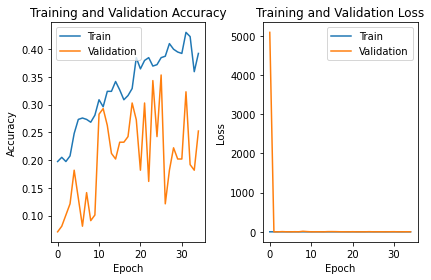

In [47]:
plot_metrics(history)

# CNN

In [49]:
input_shape = (255, 255, 3)


model3=models.Sequential()
model3.add(layers.Input(input_shape))
#Rescalling layer

model3.add(layers.Rescaling(scale=1./255))


model3.add(layers.RandomFlip("horizontal_and_vertical"))
model3.add(layers.RandomRotation(0.2))
model3.add(layers.RandomZoom(0.2))
model3.add(layers.RandomContrast(0.2))
model3.add(layers.RandomTranslation(0.2, 0.2))
# model.add(layers.RandomHeight(0.2))
# model.add(layers.RandomWidth(0.2))

model3.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu',))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu',))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu',))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(filters=256, kernel_size=(2,2), activation='relu',))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))


# Add flatten layer
model3.add(layers.Flatten())

# Add dense/dropout layers + activation functions

model3.add(layers.Dense(128, activation = 'relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(64, activation = 'relu'))
model3.add(layers.Dropout(0.3))

model3.add(layers.Dense(num_classes, activation = 'softmax'))

adamop = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 255, 255, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 255, 255, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 255, 255, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 255, 255, 3)       0         
_________________________________________________________________
random_contrast_2 (RandomCon (None, 255, 255, 3)       0         
_________________________________________________________________
random_translation_2 (Random (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)     

In [50]:
MODEL_NAME = 'CNN'
RUN_NAME = ''
log_dir = f'logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/{MODEL_NAME}{RUN_NAME}'

In [53]:
num_epochs = 70
patience = 15
patience_lr = 15

model3.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=[
                    tf.keras.metrics.CategoricalAccuracy(name=f'metrics/accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(3, name=f'metrics/top-3-accuracy'),
                    tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='metrics/F1-macro'),
                    tf.keras.metrics.AUC(multi_label=True, num_labels=num_classes, name='metrics/AUC'),
                    tf.keras.metrics.Precision(name='metrics/precision'),
                    tf.keras.metrics.Recall(name='metrics/recall'),
                    tf.keras.metrics.PrecisionAtRecall(0.99, name='metrics/P@R_99'),
                    tf.keras.metrics.PrecisionAtRecall(0.95, name='metrics/P@R_95'),
                    tf.keras.metrics.PrecisionAtRecall(0.9, name='metrics/P@R_90'),
                    tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes, name='metrics/MCC')
                ],
             )

callbacks =[
       EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience),
       ReduceLROnPlateau(monitor='val_loss', patience=patience_lr, min_lr=1e-7),       
       ModelCheckpoint(log_dir, monitor=f"val_loss", save_best_only=True, save_weights_only=True),
       TqdmCallback(),
       TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [54]:
# Train the model using the custom data generators and the debugging callback
history = model3.fit(train_generator, epochs=num_epochs, verbose=1, callbacks=callbacks, validation_data=val_generator,class_weight=class_weights)

Epoch 1/70
50/50 [==============================] - 139s 3s/step - loss: 2.0916 - metrics/accuracy: 0.1696 - metrics/top-3-accuracy: 0.4962 - metrics/F1-macro: 0.0993 - metrics/AUC: 0.5015 - metrics/precision: 0.5000 - metrics/recall: 0.0025 - metrics/P@R_99: 0.1455 - metrics/P@R_95: 0.1485 - metrics/P@R_90: 0.1485 - metrics/MCC: 0.0271 - val_loss: 1.9913 - val_metrics/accuracy: 0.1010 - val_metrics/top-3-accuracy: 0.3636 - val_metrics/F1-macro: 0.0557 - val_metrics/AUC: 0.5140 - val_metrics/precision: 0.0000e+00 - val_metrics/recall: 0.0000e+00 - val_metrics/P@R_99: 0.1445 - val_metrics/P@R_95: 0.1445 - val_metrics/P@R_90: 0.1453 - val_metrics/MCC: 0.0569
Epoch 2/70
50/50 [==============================] - 136s 3s/step - loss: 2.1178 - metrics/accuracy: 0.1797 - metrics/top-3-accuracy: 0.5089 - metrics/F1-macro: 0.1082 - metrics/AUC: 0.5373 - metrics/precision: 0.0000e+00 - metrics/recall: 0.0000e+00 - metrics/P@R_99: 0.1481 - metrics/P@R_95: 0.1520 - metrics/P@R_90: 0.1529 - metrics/

In [58]:
history.history.keys()

#print the keys  in differnt rows
for key in history.history.keys():
    print(key)






loss
metrics/accuracy
metrics/top-3-accuracy
metrics/F1-macro
metrics/AUC
metrics/precision
metrics/recall
metrics/P@R_99
metrics/P@R_95
metrics/P@R_90
metrics/MCC
val_loss
val_metrics/accuracy
val_metrics/top-3-accuracy
val_metrics/F1-macro
val_metrics/AUC
val_metrics/precision
val_metrics/recall
val_metrics/P@R_99
val_metrics/P@R_95
val_metrics/P@R_90
val_metrics/MCC
lr


### Test

Test Accuracy: 0.3142857142857143
Test Precision: 0.23766391985047636
Test Recall: 0.31428571428571433


c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


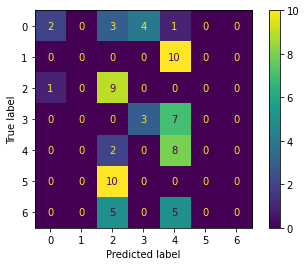

In [ ]:
test_directory = "data\\validation_final_septiembre\\"
test_image_paths = get_files(test_directory, 'jpg')
test_labels = [class2int[im.split(test_directory)[1].split('\\')[0]] for im in test_image_paths]

test_generator = CustomDataGenerator(test_image_paths, test_labels, shuffle_epoch=False)
test_predictions = model3.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)



# Obtain the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Ensure that labels are unique and match the confusion matrix
labels = np.unique(np.concatenate((test_labels, predicted_labels)))

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot()


